# Requirements

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **mean temperature** in the city of Delhi. To accomplish this use data from the past three days, which includes information such as the **mean temperature**, **humidity**, **wind speed**, and **mean pressure**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future mean temperature based on the provided historical data.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

In [ ]:
!gdown 1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC

Downloading...
From: https://drive.google.com/uc?id=1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC
To: /content/climate-data.csv
100% 78.1k/78.1k [00:00<00:00, 3.58MB/s]


## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [62]:
# Write your code here. Add as many boxes as you need.
pd.set_option('display.max_columns', None)

In [63]:
data = pd.read_csv('/content/climate-data.csv')

In [64]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [65]:
data.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Explore the dataset using visualizations of your choice.

array([[<Axes: title={'center': 'meantemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'wind_speed'}>,
        <Axes: title={'center': 'meanpressure'}>]], dtype=object)

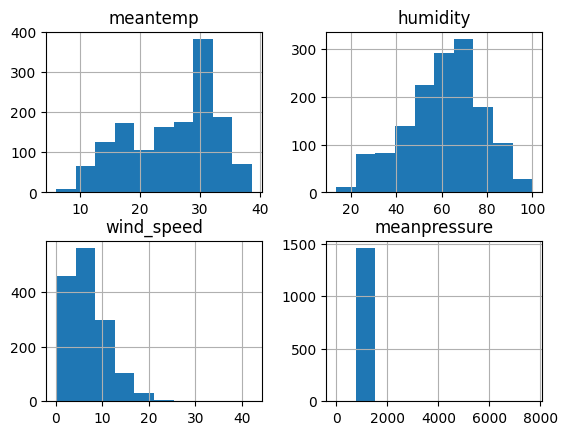

In [66]:
# Write your code here. Add as many boxes as you need.
data.hist()

<ipython-input-67-8cc8fdd6490c>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)


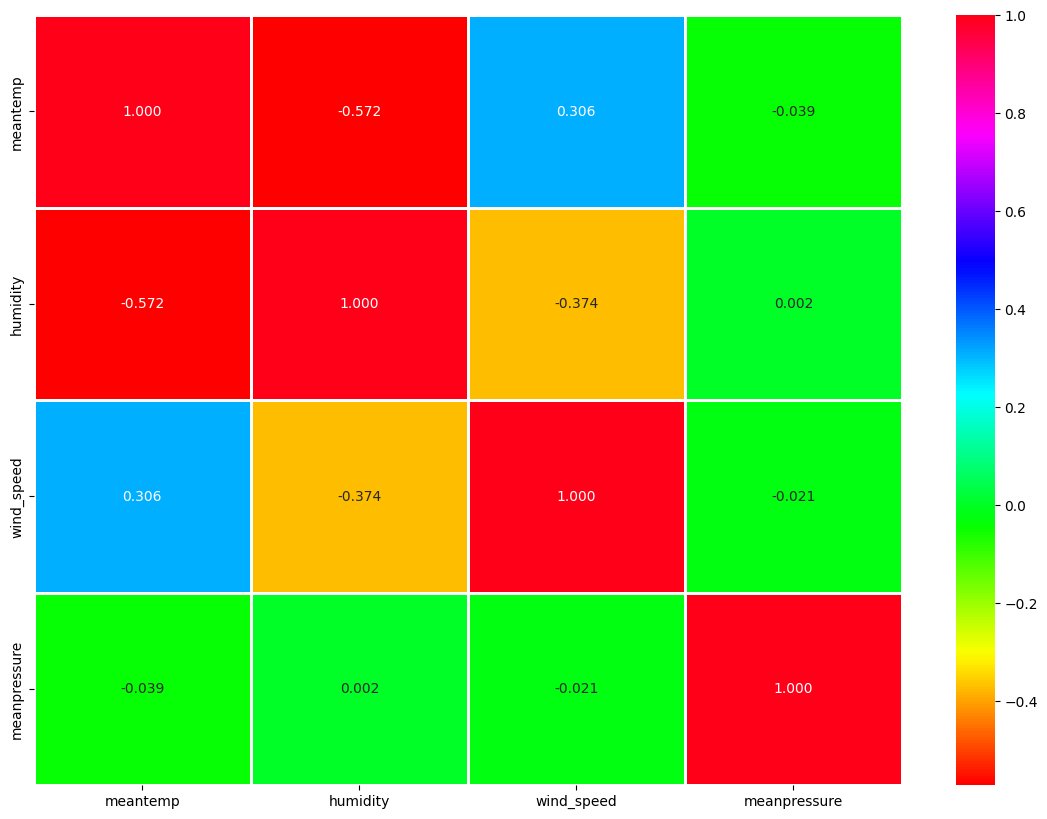

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,10))
sns.heatmap(data.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.show()

## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [68]:
# Write your code here. Add as many boxes as you need.
data.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [69]:
columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
for i in range(3,0,-1):
  for column in columns:
    data[f'{column}_{i}'] = data[column].shift(i)

In [70]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_3,humidity_3,wind_speed_3,meanpressure_3,meantemp_2,humidity_2,wind_speed_2,meanpressure_2,meantemp_1,humidity_1,wind_speed_1,meanpressure_1
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,84.500000,0.000000,1015.666667
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,NaN,NaN,NaN,NaN,10.000000,84.5,0.000000,1015.666667,7.400000,92.000000,2.980000,1017.800000
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,10.0,84.5,0.00,1015.666667,7.400000,92.0,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.4,92.0,2.98,1017.800000,7.166667,87.0,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667


In [71]:
data


,date,meantemp,humidity,wind_speed,meanpressure,meantemp_3,humidity_3,wind_speed_3,meanpressure_3,meantemp_2,humidity_2,wind_speed_2,meanpressure_2,meantemp_1,humidity_1,wind_speed_1,meanpressure_1
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,84.500000,0.000000,1015.666667
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,NaN,NaN,NaN,NaN,10.000000,84.500000,0.000000,1015.666667,7.400000,92.000000,2.980000,1017.800000
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,10.000000,84.500000,0.000000,1015.666667,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,14.000000,94.300000,9.085000,1014.350000,17.142857,74.857143,8.784211,1016.952381,16.850000,67.550000,8.335000,1017.200000
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,17.142857,74.857143,8.784211,1016.952381,16.850000,67.550000,8.335000,1017.200000,17.217391,68.043478,3.547826,1015.565217
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,16.850000,67.550000,8.335000,1017.200000,17.217391,68.043478,3.547826,1015.565217,15.238095,87.857143,6.000000,1016.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,17.217391,68.043478,3.547826,1015.565217,15.238095,87.857143,6.000000,1016.904762,14.095238,89.666667,6.266667,1017.904762


In [72]:
data.dropna(axis=0, inplace=True)

In [73]:
t = data.copy()
t.drop('humidity', axis = 'columns', inplace = True)
t.drop('wind_speed', axis = 'columns', inplace = True)
t.drop('meanpressure', axis = 'columns', inplace = True)
t.drop('date', axis = 'columns', inplace = True)

In [74]:
t

,meantemp,meantemp_3,humidity_3,wind_speed_3,meanpressure_3,meantemp_2,humidity_2,wind_speed_2,meanpressure_2,meantemp_1,humidity_1,wind_speed_1,meanpressure_1
3,8.666667,10.000000,84.500000,0.000000,1015.666667,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667
4,6.000000,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667
5,7.000000,7.166667,87.000000,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667,6.000000,86.833333,3.700000,1016.500000
6,7.000000,8.666667,71.333333,1.233333,1017.166667,6.000000,86.833333,3.700000,1016.500000,7.000000,82.800000,1.480000,1018.000000
7,8.857143,6.000000,86.833333,3.700000,1016.500000,7.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,17.217391,14.000000,94.300000,9.085000,1014.350000,17.142857,74.857143,8.784211,1016.952381,16.850000,67.550000,8.335000,1017.200000
1458,15.238095,17.142857,74.857143,8.784211,1016.952381,16.850000,67.550000,8.335000,1017.200000,17.217391,68.043478,3.547826,1015.565217
1459,14.095238,16.850000,67.550000,8.335000,1017.200000,17.217391,68.043478,3.547826,1015.565217,15.238095,87.857143,6.000000,1016.904762
1460,15.052632,17.217391,68.043478,3.547826,1015.565217,15.238095,87.857143,6.000000,1016.904762,14.095238,89.666667,6.266667,1017.904762


## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [75]:
# Write your code here. Add as many boxes as you need.
X_train, X_test, Y_train, Y_test = train_test_split(t.iloc[:,-12:],t.iloc[:,:-12], shuffle=False, test_size=0.1)

In [76]:
X_train

,meantemp_3,humidity_3,wind_speed_3,meanpressure_3,meantemp_2,humidity_2,wind_speed_2,meanpressure_2,meantemp_1,humidity_1,wind_speed_1,meanpressure_1
3,10.000000,84.500000,0.000000,1015.666667,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667
4,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667
5,7.166667,87.000000,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667,6.000000,86.833333,3.700000,1016.500000
6,8.666667,71.333333,1.233333,1017.166667,6.000000,86.833333,3.700000,1016.500000,7.000000,82.800000,1.480000,1018.000000
7,6.000000,86.833333,3.700000,1016.500000,7.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1311,29.125000,84.250000,5.912500,999.125000,30.687500,72.125000,6.375000,310.437500,32.562500,63.562500,5.450000,998.500000
1312,30.687500,72.125000,6.375000,310.437500,32.562500,63.562500,5.450000,998.500000,33.111111,63.888889,7.927778,998.777778
1313,32.562500,63.562500,5.450000,998.500000,33.111111,63.888889,7.927778,998.777778,33.800000,61.666667,4.320000,999.333333
1314,33.111111,63.888889,7.927778,998.777778,33.800000,61.666667,4.320000,999.333333,30.066667,76.000000,6.926667,1000.800000


In [77]:
Y_train

,meantemp
3,8.666667
4,6.000000
5,7.000000
6,7.000000
7,8.857143
...,...
1311,33.111111
1312,33.800000
1313,30.066667
1314,33.117647


## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Feature Reshaping

In [93]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [94]:
# Write your code here. Add as many boxes as you need.
X_train.shape

(1313, 1, 12)

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the current **mean temperature** based on the extracted features from the previous three days.

In [95]:
# Write your code here. Add as many boxes as you need.
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [96]:
K.clear_session()
model = Sequential()
model.add(LSTM(12,  activation='relu', return_sequences=True,input_shape=(1,12)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [97]:
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

In [98]:
# Write your code here. Add as many boxes as you need.
history = model.fit(X_train, Y_train, epochs=15, batch_size=50,  verbose=1, validation_split=0.2, shuffle=False)

Epoch 1/15
21/21 [==============================] - 4s 41ms/step - loss: 24.8751 - accuracy: 0.0000e+00 - val_loss: 25.3520 - val_accuracy: 0.0000e+00
Epoch 2/15
21/21 [==============================] - 0s 10ms/step - loss: 24.8577 - accuracy: 0.0000e+00 - val_loss: 25.3288 - val_accuracy: 0.0000e+00
Epoch 3/15
21/21 [==============================] - 0s 12ms/step - loss: 24.8303 - accuracy: 0.0000e+00 - val_loss: 25.2902 - val_accuracy: 0.0000e+00
Epoch 4/15
21/21 [==============================] - 0s 12ms/step - loss: 24.7843 - accuracy: 0.0000e+00 - val_loss: 25.2208 - val_accuracy: 0.0000e+00
Epoch 5/15
21/21 [==============================] - 0s 12ms/step - loss: 24.7082 - accuracy: 0.0000e+00 - val_loss: 25.1179 - val_accuracy: 0.0000e+00
Epoch 6/15
21/21 [==============================] - 0s 10ms/step - loss: 24.6125 - accuracy: 0.0000e+00 - val_loss: 25.0243 - val_accuracy: 0.0000e+00
Epoch 7/15
21/21 [==============================] - 0s 12ms/step - loss: 24.5291 - accuracy: 0

Use the trained model to make predictions for the test set.

In [ ]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

In [ ]:
# Write your code here. Add as many boxes as you need.

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to perform a sentiment analysis on a dataset consisting of wine reviews. The dataset contains two attributes: **description* and **points**. The description is a brief text describing the wine and the points which represents a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is exceptional based on its review.

The greater part of the code for the solution is already given. You need to define a tokenizer to tokenize the given texts and a deep neural network model that will be used for the classification task at hand. Fill in only the missing code blocks.

## Requirements

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Downloading the Wine Reviews Dataset

In [ ]:
!gdown 1fz9449M9Owofy6CYrKzkGwXKesI32B8u

## Exploring the Climate Dataset

Load the dataset into a `pandas` data frame.

In [ ]:
df = pd.read_csv('wine-reviews.csv')

In [ ]:
df.head()

## Feature Extraction

Extract the feature `exceptional` for each wine review.

In [ ]:
df['exceptional'] = df['points'].apply(lambda elem: 1 if elem >= 90 else 0)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

In [ ]:
X, y = df['description'], df['exceptional']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Text Tokenization

Use tokenizer to convert raw text into a sequence of tokens.

In [ ]:
# Write your code here. Add as many boxes as you need.

## Padding
Pad each sequence to maximum length of 16.

In [ ]:
# Write your code here. Add as many boxes as you need.

## Deep Neural Network

Define Deep Neural Network model to predict if a specific wine is exceptional or not based on the tokenized and padded wine reviews.

In [ ]:
# Write your code here. Add as many boxes as you need.

Compile the previously defined model specifying loss function, optimizer and evaluation metrics.

In [ ]:
# Write your code here. Add as many boxes as you need.

Fit the compiled model on the train set specifying the percent for validation, batch_size, and number of epochs.

In [ ]:
# Write your code here. Add as many boxes as you need.

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

Use the trained model to make predictions for the test set.

In [ ]:
y_pred = model.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
print(classification_report(y_test, np.round(y_pred)))